In [ ]:
%pip install --upgrade --quiet praw pypdf langchain-core langgraph langchain_openai langchain_anthropic langchain-community scikit-learn bs4 tavily-python

## LangGraph Research Assistant

We'll build a research assistant that combines 3 themes: 

1) `Report Generation` -- [Reports provide greater value than question-answering tools used in many RAG systems](https://jxnl.co/writing/2024/06/05/predictions-for-the-future-of-rag/). This is because reports offer more than just answers; they are more refined tools for decision-making. Reports can save costs by replacing the need for multiple employees or expensive processes.

2) `Automating multi-step research workflows` -- There are some interesting examples of AI-mediated workflows that replace knowlege work. For example, [deal flow automation for VCs](https://x.com/MaxBrodeurUrbas/status/1806380947606253960) that analyzes pitch decks (e.g., extracts all metrics, finds founder LinkedIns + extracts their background, writes to Notion).

3) `Multi-perspective AI assistants` -- A generally powerful approach, as seen in papers like [STORM](https://github.com/langchain-ai/langgraph/blob/main/examples/storm/storm.ipynb), is to create AI assistants that take on various roles and have them simultanously research about a topic from different angles.

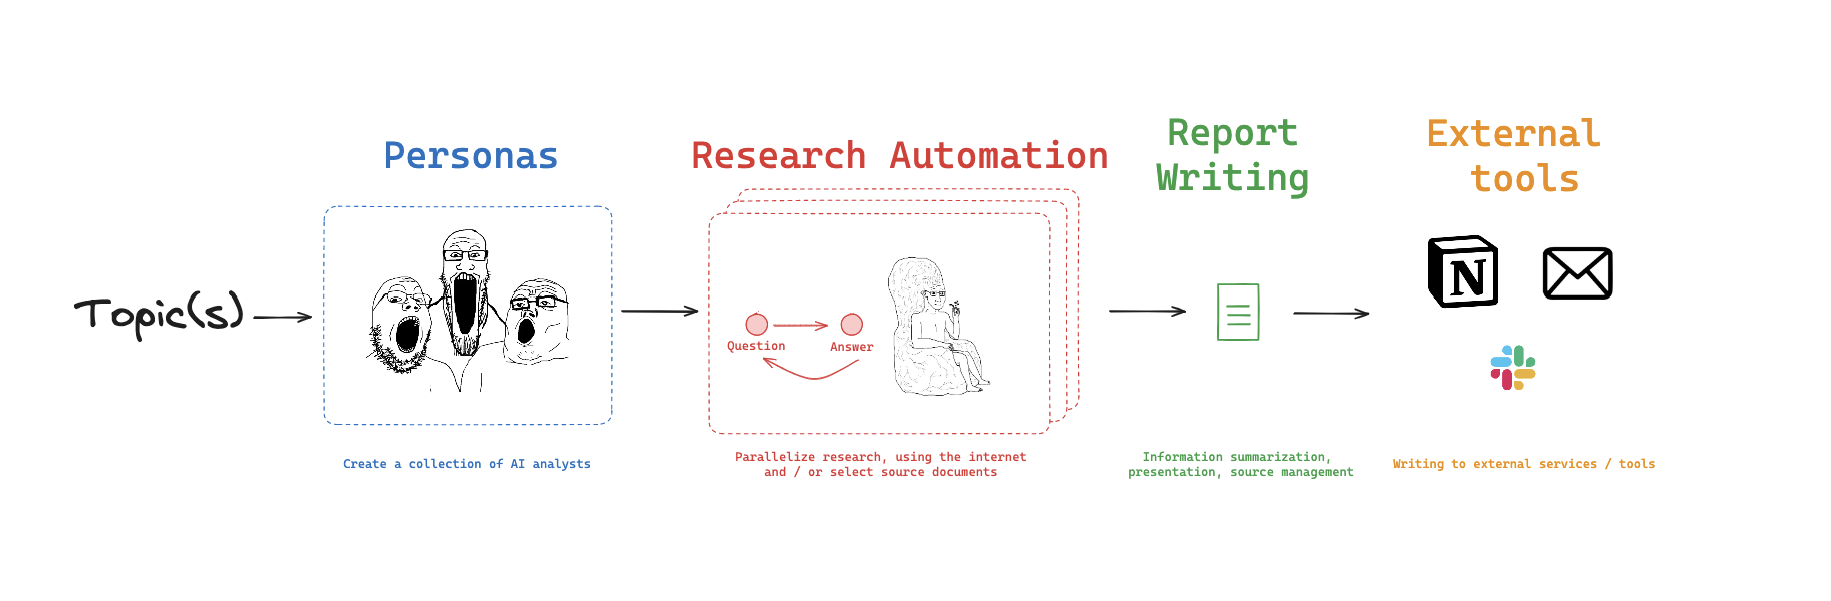

### Approach

As an example, we'll apply these ideras to explore the [llama3.1 release](https://ai.meta.com/blog/meta-llama-3-1/).

And we'll lay out our assistant like this: 

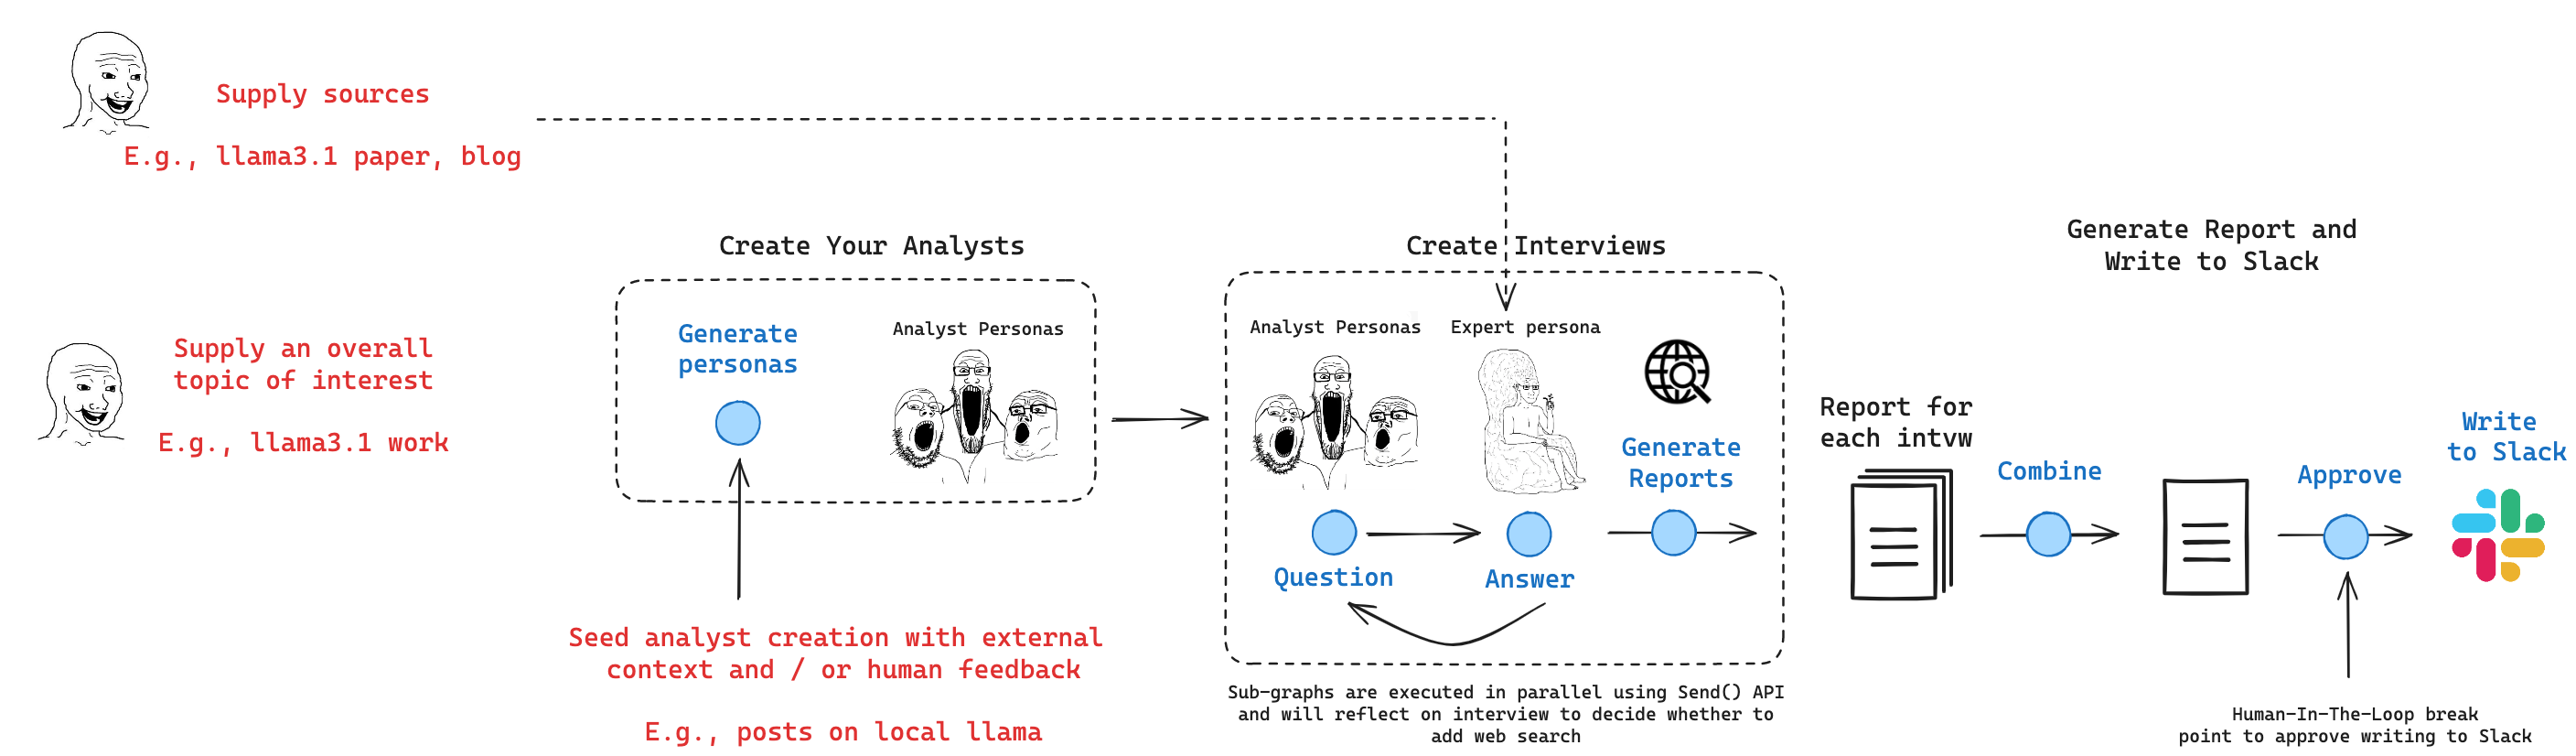

It will combine a few LangGraph concepts:

1) `Huamn In The Loop` -- We will use human in the loop to review personas and [add user feedback](https://langchain-ai.github.io/langgraph/how-tos/human_in_the_loop/time-travel/) for any personas to include. In addition, we will use [a HIL breakpoint](https://langchain-ai.github.io/langgraph/how-tos/human_in_the_loop/breakpoints/) to approve the final step of writing to Slack.

2) `Map-Reduce` -- We will parallelize the interviews and report generation per interview using [map-reduce](https://langchain-ai.github.io/langgraph/how-tos/map-reduce/), and then write a consolidated final report as well as an introduction based upon all the interviews.

3) `Sub-graphs` -- Each interview will be its own [subgraph](https://langchain-ai.github.io/langgraph/how-tos/subgraph/), with its own state. We found that writing a small report within interview subgraph, and then combining into the final, resulted in better quality than attempting to write the full / final report in a single step from all the interviews.

4) `Conversation` -- We will use messages to capture the chat between our AI analysts and experts. The conversation will occour automatically and in parallel within sub-graphs. 

5) `RAG and report generation` -- Our AI expert will use RAG to answer questions posed by our analysts. The conversation will be captured, and used as a basis for generating a report. 

### Specify Topic and Content

First, select the topic of interest.

In [1]:
# Overall topic
topic = "Interesting and non-obvious insights based upon the Meta LLlama3.1 open source LLM work"

#### Context for creating the analysts

Next, we want to create our analysts. 

Here, we have some options:

1. Prompt an LLM with a few specific themes

2. Let an LLM choose the specifics based upon some provided context

We choose option 2, using either comments from localLLaMA reddit posts or from Zuck's blog post.

The idea here is that we use context to select more specific and interesting focus ares for our analysts. 

In [5]:
import os
import praw

# Reddit creds
reddit_client_id = os.getenv('REDDIT_CLIENT_ID')
reddit_client_secret = os.getenv('REDDIT_CLIENT_SECRET')

# URL of the Reddit post
url = 'https://www.reddit.com/r/LocalLLaMA/comments/1eabf4l/lets_discuss_llama31_paper_a_lot_of_details_on/'

# Initialize the Reddit instance
reddit = praw.Reddit(client_id=reddit_client_id,
                     client_secret=reddit_client_secret,
                     user_agent='Local Llama Loader')

# Fetch the submission
submission = reddit.submission(url=url)

# Load the comments
submission.comments.replace_more(limit=None)
comments = submission.comments.list()

# Concatenate comments into a single string
ANALYST_TOPIC_GENERATION_CONTEXT = "\n *** user commnent *** \n".join([comment.body for comment in comments])

We can also use Mark Zuckerberg's letter about llama3.1.

In [6]:
from langchain_community.document_loaders import WebBaseLoader

# Load Mark's Letter from the web 
url = "https://about.fb.com/news/2024/07/open-source-ai-is-the-path-forward/"
ANALYST_TOPIC_GENERATION_CONTEXT_BLOG = WebBaseLoader(url).load()

#### Context for your expert 

Next, we create our expert. 

Here we can use a few approaches:

1. `RAG:` Simply give the expert specific context (e.g., papers, source materials)

2. `Search:` Allow the expert to use web search.

Of course, we can also combine these.

Here, we simply use RAG as a starting point.
 
We can use the [full llama3.1 paper](https://scontent-sjc3-1.xx.fbcdn.net/v/t39.2365-6/453304228_1160109801904614_7143520450792086005_n.pdf?_nc_cat=108&ccb=1-7&_nc_sid=3c67a6&_nc_ohc=E2ya34Gb5vsQ7kNvgFuM2d8&_nc_ht=scontent-sjc3-1.xx&oh=00_AYD0ZeOA_-SvZsYvqbF4Gjf27w9eE66P2mPs7G0YDdeOUw&oe=66B06507), which we save to a local path, `/Users/rlm/Desktop/llama3_1.pdf`.

In [7]:
# Full llama3.1 paper
from langchain_community.document_loaders import PyPDFLoader

# Load paper from local PDF
loader = PyPDFLoader("/Users/rlm/Desktop/LangGraph-Assistant/llama3_1.pdf")
pages = loader.load_and_split()
EXPERT_CONTEXT_PAPER = "\n *** *** *** \n".join([page.page_content for page in pages])

If the context is large, as we have here, then an index can reduce the tokens used for generation.

In [8]:
from langchain_community.vectorstores import SKLearnVectorStore
from langchain_core.documents import Document
from langchain_openai import OpenAIEmbeddings

# Embeddings
embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

# Full paper, except for references 
all_pages_except_references=pages[:100]

# Index
vectorstore = SKLearnVectorStore.from_documents(all_pages_except_references,embedding=embeddings)

# Build retriever
retriever = vectorstore.as_retriever(k=10)

We can also supplement this with a blog post.

In [10]:
from langchain_community.document_loaders import WebBaseLoader

# Load a technical blog post from the web 
url = "https://ai.meta.com/blog/meta-llama-3-1/"
EXPERT_CONTEXT_BLOG = WebBaseLoader(url).load()

### State

Here, we outline the states that we will use for our graph.

#### Graph State

`InterviewState` is the "inner state" in our final graph. 

* This will be used for each interview between expert and analyst.

`ResearchGraphState` is the "outer state" in our final graph.

* Here, we will collate results from all interviews.
* We will combine these into the final report.

In [22]:
# Set a path for saving the state of your graph
save_db_path = "/Users/rlm/Desktop/LangGraph-Assistant/assistant.db"

In [63]:
import operator
from typing import List, Optional
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages
from langchain_core.messages import AnyMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field

class Analyst(BaseModel):
    affiliation: str = Field(
        description="Primary affiliation of the analyst.",
    )
    name: str = Field(
        description="Name of the analyst.", pattern=r"^[a-zA-Z0-9_-]{1,64}$"
    )
    role: str = Field(
        description="Role of the analyst in the context of the topic.",
    )
    description: str = Field(
        description="Description of the analyst focus, concerns, and motives.",
    )

    @property
    def persona(self) -> str:
        return f"Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}\nDescription: {self.description}\n"

class Perspectives(BaseModel):
    analysts: List[Analyst] = Field(
        description="Comprehensive list of analysts with their roles and affiliations.",
    )

class InterviewState(TypedDict):
    topic: str
    messages: Annotated[List[AnyMessage], add_messages]
    analyst: Analyst
    editor_feedback: str
    interviews: list # This key is duplicated between "inner state" ...
    reports: list # This key is duplicated between "inner state" ...

class ResearchGraphState(TypedDict):
    topic: str
    analysts: List[Analyst]
    interviews: Annotated[list, operator.add] # ... and "outer state"
    reports: Annotated[list, operator.add] # ... and "outer state"
    final_report: str
    analyst_feedback: str 
    editor_feedback: str 

class ResearchGraphStateInput(TypedDict):
    topic: str
    max_analysts: int

#### Optional: Data model for Slack

You can write your report anywhere you want. We chose to showcase Slack as one potential destination.

The below data model can be used to write your output to Slack, which uses [blocks](https://app.slack.com/block-kit-builder/T04F8K3FZB5#%7B%22blocks%22:%5B%7B%22type%22:%22section%22,%22text%22:%7B%22type%22:%22mrkdwn%22,%22text%22:%22Hello,%20Assistant%20to%20the%20Regional%20Manager%20Dwight!%20*Michael%20Scott*%20wants%20to%20know%20where%20you'd%20like%20to%20take%20the%20Paper%20Company%20investors%20to%20dinner%20tonight.%5Cn%5Cn%20*Please%20select%20a%20restaurant:*%22%7D%7D,%7B%22type%22:%22divider%22%7D,%7B%22type%22:%22section%22,%22text%22:%7B%22type%22:%22mrkdwn%22,%22text%22:%22*Farmhouse%20Thai%20Cuisine*%5Cn:star::star::star::star:%201528%20reviews%5Cn%20They%20do%20have%20some%20vegan%20options,%20like%20the%20roti%20and%20curry,%20plus%20they%20have%20a%20ton%20of%20salad%20stuff%20and%20noodles%20can%20be%20ordered%20without%20meat!!%20They%20have%20something%20for%20everyone%20here%22%7D,%22accessory%22:%7B%22type%22:%22image%22,%22image_url%22:%22https://s3-media3.fl.yelpcdn.com/bphoto/c7ed05m9lC2EmA3Aruue7A/o.jpg%22,%22alt_text%22:%22alt%20text%20for%20image%22%7D%7D,%7B%22type%22:%22section%22,%22text%22:%7B%22type%22:%22mrkdwn%22,%22text%22:%22*Kin%20Khao*%5Cn:star::star::star::star:%201638%20reviews%5Cn%20The%20sticky%20rice%20also%20goes%20wonderfully%20with%20the%20caramelized%20pork%20belly,%20which%20is%20absolutely%20melt-in-your-mouth%20and%20so%20soft.%22%7D,%22accessory%22:%7B%22type%22:%22image%22,%22image_url%22:%22https://s3-media2.fl.yelpcdn.com/bphoto/korel-1YjNtFtJlMTaC26A/o.jpg%22,%22alt_text%22:%22alt%20text%20for%20image%22%7D%7D,%7B%22type%22:%22section%22,%22text%22:%7B%22type%22:%22mrkdwn%22,%22text%22:%22*Ler%20Ros*%5Cn:star::star::star::star:%202082%20reviews%5Cn%20I%20would%20really%20recommend%20the%20%20Yum%20Koh%20Moo%20Yang%20-%20Spicy%20lime%20dressing%20and%20roasted%20quick%20marinated%20pork%20shoulder,%20basil%20leaves,%20chili%20&%20rice%20powder.%22%7D,%22accessory%22:%7B%22type%22:%22image%22,%22image_url%22:%22https://s3-media2.fl.yelpcdn.com/bphoto/DawwNigKJ2ckPeDeDM7jAg/o.jpg%22,%22alt_text%22:%22alt%20text%20for%20image%22%7D%7D,%7B%22type%22:%22divider%22%7D,%7B%22type%22:%22actions%22,%22elements%22:%5B%7B%22type%22:%22button%22,%22text%22:%7B%22type%22:%22plain_text%22,%22text%22:%22Farmhouse%22,%22emoji%22:true%7D,%22value%22:%22click_me_123%22%7D,%7B%22type%22:%22button%22,%22text%22:%7B%22type%22:%22plain_text%22,%22text%22:%22Kin%20Khao%22,%22emoji%22:true%7D,%22value%22:%22click_me_123%22,%22url%22:%22https://google.com%22%7D,%7B%22type%22:%22button%22,%22text%22:%7B%22type%22:%22plain_text%22,%22text%22:%22Ler%20Ros%22,%22emoji%22:true%7D,%22value%22:%22click_me_123%22,%22url%22:%22https://google.com%22%7D%5D%7D%5D%7D). 

Also, ensure that [you have set up a webhook](https://api.slack.com/messaging/webhooks) to post messages to slack from the app.

I set this url as an env variable, `LANCE_BOT_SLACK_URL`.

In [12]:
import os

# Web hook for Slack Channel
slack_bot_url = os.getenv('LANCE_BOT_SLACK_URL')

In [14]:
from typing import Union

# Data model for Slack
class TextObject(BaseModel):
    type: str = Field(
        ..., 
        description="The type of text object, should be 'mrkdwn' or 'plain_text'.", 
        example="mrkdwn"
    )
    text: str = Field(
        ..., 
        description="The text content.",
        example="Hello, Assistant to the Regional Manager Dwight! ..."
    )

class SectionBlock(BaseModel):
    type: str = Field(
        "section", 
        description="The type of block, should be 'section'.", 
        const=True
    )
    text: TextObject = Field(
        ..., 
        description="The text object containing the block's text."
    )

class DividerBlock(BaseModel):
    type: str = Field(
        "divider", 
        description="The type of block, should be 'divider'.", 
        const=True
    )

class SlackBlock(BaseModel):
    blocks: List[Union[SectionBlock, DividerBlock]] = Field(
        ..., 
        description="A list of Slack block elements."
    )

### LLM

Set the LLMs that we'll use.

These are flexible, but keep in mind: 

* `llm` should support tool use.
* `llm` should have sufficient context window for handling multi-turn conversations.
* `report_writer_llm` ideally is well optimized for writing, as it will be used to turn conversations into reports.

In [ ]:
import getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("ANTHROPIC_API_KEY")
_set_env("OPENAI_API_KEY")

In [64]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o", temperature=0) 

In [65]:
from langchain_anthropic import ChatAnthropic
report_writer_llm = ChatAnthropic(model="claude-3-5-sonnet-20240620", temperature=0) 

### Tools

We will use [Tavily](https://tavily.com/) as a search tool.

But free queries with Tavily are limited.

`DuckDuckGoSearchAPIWrapper` is another easy option.

In [ ]:
_set_env("TAVILY_API_KEY")

### Tracing

Set up [LangSmith](https://docs.smith.langchain.com/) for tracing.

In [ ]:
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
_set_env("LANGCHAIN_API_KEY")

### Create Analysts

Create analysts based upon the `ANALYST_TOPIC_GENERATION_CONTEXT`.

The primary insight here: ground analyst generation on themes or questions discussed in `ANALYST_TOPIC_GENERATION_CONTEXT`.

In [71]:
from langchain_core.prompts import MessagesPlaceholder
from langchain_core.runnables import chain as as_runnable
from langchain_core.messages import AIMessage, HumanMessage

gen_perspectives_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            
            """
            You are tasked with creating a set of AI analyst personas. 
            
            Follow these instructions carefully:

            1. First, review the research topic:
            
            {topic}
            
            2. Examine any documents that have been optionally provided to guide creation of the analysts:
            
            {documents}

            3. Examine any editorial feedback that has been optionally provided to guide creation of the analysts: 
            
            {analyst_feedback}  
            
            4. Think carefully about anything provided about to guide analst creation related to the research topic.
            
            5. Determine the most interesting themes and questions. 
            
            6. Assign AI analyst persona to each themes and / or question. 
            
            7. Choose the top {max_analysts} themes. The maximum number of personas you should create is:
            
            {max_analysts}""",
            
        ),
    ]
)

@as_runnable
def generate_analysts(state: ResearchGraphState):
    """ Node to generate analysts """

    # Get topic and max analysts from state
    topic = state["topic"]
    max_analysts = state["max_analysts"]
    analyst_feedback = state.get("analyst_feedback", "")

    # Generate analysts
    gen_perspectives_chain = gen_perspectives_prompt | llm.with_structured_output(Perspectives)
    perspectives = gen_perspectives_chain.invoke({"documents": ANALYST_TOPIC_GENERATION_CONTEXT, 
                                                  "topic": topic, 
                                                  "analyst_feedback": analyst_feedback, 
                                                  "max_analysts": max_analysts})
    
    # Write the list of analysis to state
    return {"analysts": perspectives.analysts}

We can test this.

Note that we can pass in user feedback via `analyst_feedback`, which helps us customize the analysts. 

In the final graph, `analyst_feedback` will come in via Human-In-The-Loop. 

In [72]:
# Test
initial_state = {"topic": topic, 
                 "analyst_feedback": "Make sure to include an analyst on the training strategy -- e.g., # of GPUs and network.",
                 "max_analysts": 6}

perspectives = generate_analysts.invoke(initial_state)

In [20]:
from pprint import pprint
for a in perspectives['analysts']:
    print("---")
    pprint(a.description)
    print("---")

---
('Dr. Martinez focuses on the training strategies employed in Llama 3.1, '
 'including the number of GPUs, network configurations, and optimization '
 'techniques. She is particularly interested in the efficiency and scalability '
 'of the training process.')
---
---
('Prof. Green examines the data quality and filtering techniques used in Llama '
 '3.1. He is concerned with the ethical implications of data filtering, '
 'especially the potential exclusion of valuable but outlier data.')
---
---
('Dr. Khan analyzes the architectural choices in Llama 3.1, focusing on the '
 'decision to avoid recent innovations like MoE and InstructGPT. She explores '
 'the impact of these choices on model performance and future scalability.')
---
---
('Dr. Lee investigates the quantization techniques used in Llama 3.1, '
 'particularly the novel approach to evaluating quantization errors. He is '
 'interested in the balance between model performance and computational '
 'efficiency.')
---
---
('Dr. 

### Ask Questions

Prompt each analyst to ask questions to the expert.

In [67]:
gen_qn_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            
            """You are an experienced analyst tasked with interviewing an expert to learn about a specific topic. 

            Your goal is boil down to non-obvious and specific insights related to your topic:

            1. Non-obvious: Insights that people will find surprising.
            
            2. Specific: Insights that avoid generalities and include specific examples from the exprt.
    
            Here is your topic of focus and set of goals: {persona}
            
            Begin by introducing yourself using a name that fits your persona, and then ask your question.

            Continue to ask questions to drill down and refine your understanding of the topic.
            
            When you are satisfied with your understanding, complete the interview with: "Thank you so much for your help!"

            Remember to stay in character throughout your response, reflecting the persona and goals provided to you.""",
        
        ),
        MessagesPlaceholder(variable_name="messages", optional=True),
    ]
)

@as_runnable
def generate_question(state: InterviewState):
    """ Node to generate a question """

    # Get state
    analyst = state["analyst"]
    messages = state["messages"]

    # Generate question 
    gen_question_chain = gen_qn_prompt.partial(persona=analyst.persona) | llm   
    result = gen_question_chain.invoke({"messages": messages})
    
    # Write messages to state
    return {"messages": [result]}

Here, we can test question generation.

We select one analyst to test, at random.

We start the conversation with an example prompt from the expert, `So you said you were researching ...`.

The analyst will then generate a question.

In [22]:
# Test
messages = [HumanMessage(f"So you said you were researching {topic}?")]

# Analyst to test 
i = 0
interview_state = {"analyst": perspectives["analysts"][i], "messages": messages}
question = generate_question.invoke(interview_state)
messages.extend(question['messages'])
messages

[HumanMessage(content='So you said you were researching Interesting and non-obvious insights based upon the Meta LLlama3.1 open source LLM work?'),
 AIMessage(content="Hello, Dr. Martinez. My name is Alex Thompson, and I'm an analyst keen on understanding the intricacies of training strategies for Llama 3.1. I appreciate you taking the time to share your expertise with me.\n\nTo start, could you provide a non-obvious insight about the number of GPUs used in training Llama 3.1? Specifically, how does the number of GPUs impact the efficiency and scalability of the training process?\n\n", response_metadata={'token_usage': {'completion_tokens': 90, 'prompt_tokens': 267, 'total_tokens': 357}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_4e2b2da518', 'finish_reason': 'stop', 'logprobs': None}, id='run-9ce5ee4e-aa39-41ec-8319-c48a9df063d1-0', usage_metadata={'input_tokens': 267, 'output_tokens': 90, 'total_tokens': 357})]

### Create Expert

Prompt the expert to answer questions from the analyst.

You can be flexible with your approach here. 

If your raw context is small, then simply stuff the full `EXPERT_CONTEXT` directly.

Below, we index `EXPERT_CONTEXT` because it is the full llama3.1 paper with >90k tokens! 

So, we use the index we created above to retrieve relevang pages from the paper. And we combine these with a short summary blog.

In [68]:
gen_expert_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            
            """You are an expert on the topic of {topic}.
            
            You are being interviewed by an analyst who focused on learning about a specific topic. 
            
            Your goal is to share non-obvious and specific insights related to your topic:

            1. Non-obvious: Insights that people will find surprising and therefore interesting.
            
            2. Specific: Insights that avoid generalities and include specific examples from the exprt.

            Here is the context you should use to inform your answers:
            {context}

            When answering questions, follow these guidelines:
            
            1. Use only the information provided in the context. Do not introduce external information or make assumptions beyond what is explicitly stated in the context.
                     
            2. If a question cannot be answered based on the given context, state that you don't have enough information to provide a complete answer.
            
            Remember, your ultimate goal is to help the analyst drill down to specific and non-obvious insights about the topic.""",
            
        ),
        
            MessagesPlaceholder(variable_name="messages", optional=True),
        ]
)

@as_runnable
def generate_answer(state: InterviewState):
    """ Node to answer a question """

    # Get state
    topic = state["topic"]
    messages = state["messages"]

    # Get context from the index of the paper
    retrieved_docs = retriever.invoke(messages[-1].content)

    # Add the technical blog post
    retrieved_docs.extend(EXPERT_CONTEXT_BLOG)

    # Format
    relevant_docs = "\n *** \n".join([f"Document # {i}\n{p.page_content}" for i, p in enumerate(retrieved_docs, start=1)])
    
    # Answer question
    answer_chain = gen_expert_prompt | llm
    answer = answer_chain.invoke({'messages': messages,
                                  'topic': topic,
                                  'context': relevant_docs})  
    
    # Name the message as coming from the expert
    # We use this later to count the number of times the expert has answered
    answer.name = "expert"
    
    # Append it to state
    return {"messages": [answer]}

In [24]:
# Test
interview_state = {"analyst": perspectives["analysts"][i], 
                   "topic": topic,
                   "messages": messages}

answer = generate_answer.invoke(interview_state)
messages.extend(answer['messages'])
messages

[HumanMessage(content='So you said you were researching Interesting and non-obvious insights based upon the Meta LLlama3.1 open source LLM work?'),
 AIMessage(content="Hello, Dr. Martinez. My name is Alex Thompson, and I'm an analyst keen on understanding the intricacies of training strategies for Llama 3.1. I appreciate you taking the time to share your expertise with me.\n\nTo start, could you provide a non-obvious insight about the number of GPUs used in training Llama 3.1? Specifically, how does the number of GPUs impact the efficiency and scalability of the training process?\n\n", response_metadata={'token_usage': {'completion_tokens': 90, 'prompt_tokens': 267, 'total_tokens': 357}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_4e2b2da518', 'finish_reason': 'stop', 'logprobs': None}, id='run-9ce5ee4e-aa39-41ec-8319-c48a9df063d1-0', usage_metadata={'input_tokens': 267, 'output_tokens': 90, 'total_tokens': 357}),
 AIMessage(content='Certainly! One non-obvious insight 

### Interview between expert and analyst

Now, we've tested answer and question generation in isolation.

We combine these into an interview graph.

Use `max_num_turns` to set the number of times you want the expert to answer.

Also, we will check for `"Thank you so much for your help"` in each question. 

Above, we prompted the analyst to say then when they are satisfied / done with the interview.

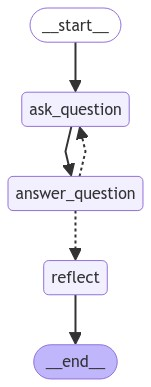

In [107]:
from IPython.display import Image, display
from langgraph.graph import END, StateGraph, START
from langgraph.checkpoint.memory import MemorySaver
from langchain_community.tools.tavily_search import TavilySearchResults

# Max turns
max_num_turns = 3

# Conditional edge
def route_messages(state: InterviewState, 
                   name: str = "expert"):

    """ Route between question and answer """
    
    # Get messages
    messages = state["messages"]

    # Check the number of expert answers 
    num_responses = len(
        [m for m in messages if isinstance(m, AIMessage) and m.name == name]
    )

    # End if expert has answered more than the max turns
    if num_responses >= max_num_turns:
        return "reflect"

    # This router is perform after each question - answer pair 
    # Get the last question asked to check if it signals the end of discussion
    last_question = messages[-2]
    
    if "Thank you so much for your help" in last_question.content:
        return "reflect"
    return "ask_question"

# Node
def reflect(state: InterviewState):

    """ Reflect on the interview, assess whether web search is needed """

    # Get messages state
    messages = state['messages']

    # Get query for reflection
    gen_search_query = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                
                """You will be given a conversation between an analyst and an expert. 
                
                Your task is to assess whether the expert's answers fully address the analyst's questions.
                
                And also your task is to determine if additional web search would be beneficial.
    
                Carefully analyze the conversation by following these steps:
                1. Identify the main questions asked by the analyst.
                2. Examine the expert's responses to each question.
                3. Determine if any questions were left unanswered or only partially addressed.
                4. Consider if there are any gaps in information or areas that could benefit from additional research.
    
                Based on your analysis, decide whether the conversation would benefit from an additional web search. 
                
                Output your decision as a single word, either 'yes' or 'no':
                
                If your decision is 'yes', complete the following additional steps:
                1. Reflect on the conversation and identify the key topics or questions that were not fully addressed.
                2. Generate a concise search query that would best capture the information needed to fill in the gaps.
                3. Provide a brief explanation of your reasoning for suggesting a web search.""",
                
            ),
            
                MessagesPlaceholder(variable_name="messages", optional=True),
            ]
    )

    # Schema 
    class SearchQuery(BaseModel):
        search: str = Field(..., description="Indicate whether to perform a search. Allowed values are 'yes' or 'no'.")
        search_query: Optional[str] = Field(None, description="The search query to use if search is 'yes'.")
        reasoning: Optional[str] = Field(None, description="Reasoning for performing additional search to supplement the interview.")

    # Reflect
    query_gen_chain = gen_search_query | llm.with_structured_output(SearchQuery)
    result = query_gen_chain.invoke({'messages': messages})

    # Perform web search
    if result.search.lower() == 'yes':

        # Search tool
        web_search_tool = TavilySearchResults(k=3)
        
        # Get search results
        search_results = web_search_tool.invoke(result.search_query)
        formatted_search_results = "\n\n".join([f"Added web search result # {i}\n{search['content']}" for i, search in enumerate(search_results, start=1)])

        # Append it to state
        return {"messages": [AIMessage(content=formatted_search_results)]}
    
# Add nodes and edges 
interview_builder = StateGraph(InterviewState)
interview_builder.add_node("ask_question", generate_question)
interview_builder.add_node("answer_question", generate_answer)
interview_builder.add_node("reflect", reflect)

# Flow
interview_builder.add_edge(START, "ask_question")
interview_builder.add_edge("ask_question", "answer_question")
interview_builder.add_conditional_edges("answer_question", route_messages,['ask_question','reflect'])
interview_builder.add_edge("reflect", END)

# Set up memory
memory = MemorySaver()

# Interview 
interview_graph = interview_builder.compile(checkpointer=memory).with_config(run_name="Conduct Interviews")

# View
display(Image(interview_graph.get_graph().draw_mermaid_png()))

Now, we can test the full conversation.

In [108]:
# Test
messages = [HumanMessage(f"So you said you were writing an article on {topic}?")]
i = 0 # analyst to test 
interview_state = {"analyst": perspectives["analysts"][i], "messages": messages}

# Thread
thread = {"configurable": {"thread_id": "2"}}

# Run
interview = await interview_graph.ainvoke(interview_state, thread)

We can get the state for the full interview.

In [109]:
full_interview_state = interview_graph.get_state(thread).values["messages"]

And we can look at specific messages.

In [110]:
full_interview_state[-1].content[0:250]

'Added web search result # 1\nModel developer: Meta. Model Architecture: Llama 3.1 is an auto-regressive language model that uses an optimized transformer architecture. The tuned versions use supervised fine-tuning (SFT) and reinforcement learning with'

[Here](https://smith.langchain.com/public/b111835e-97b2-4b7e-a544-32ab277c4af6/r) is the LangSmith trace for one interview. 

We can see: 

* The interview took `43 sec`
* The interview used `36k tokens`

You can modify your RAG parameters (e.g., use a smaller context, smaller chunk size, fewer chunks) to reduce the token usage. 

You can also redue the allowed numbner of turns to reduce both token usage and time.

### Section writing

Write a section of the overall report based upon the interview.

In [52]:
from langchain_core.messages import get_buffer_string
from langchain_core.output_parsers import StrOutputParser

report_gen_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            
            """You are an expert technical analyst, writer, and editor. You will be given an interview.

            You will turn this interview into a short easily digestible article following these guidelines:

            1. Carefully analyze the content of the interview. 

            2. Use markdown ## header for the report title.

            3. Use markdown ### header for the first section of the report and call this "Context".

            4. In the "Context" section, setup the primary insight or surprise.

            - Give context on the problem, insight, or surprise that the interview uncovered

            - Give some examples of previous ways people have tried to address the problem

            - And / or give examples of ways people previously thought about the issue

            5. Use markdown ### header for the second section of the report and call this "Why this is interesting".

            6. In the "Why this is interesting" section, lay out the the insight or surprise that the interview uncovered. 

            - Focus on what is non-obvious: Include insights from the interview that are surprising.
            
            - Focus on what is specific: Avoid generalities and include specific examples from the interview.

            7. Do not mention the names of the interviewers or expert in your report.
                           
            8. If editor feedback is provided, incorporate those points seamlessly into your report.
            
            9. Aim for ~250 words maximum for your short short easily digestible article.""",
        
        ),
        ("human", """Here are the interviews conducted with experts on this topic:
                        <interviews>
                        {interviews}
                        </interviews>
            
                        Here is any editor feedback that should be incorporated into the report:
                        <editor_feedback>
                        {editor_feedback}
                        </editor_feedback>"""),
    ]
)

@as_runnable
def generate_report(state: InterviewState):
    """ Node to generate report based upon interview """

    # State 
    topic = state["topic"]
    interviews = state["interviews"]
    editor_feedback = state.get("editor_feedback", [])

    # Full set of interviews
    formatted_str_interview = "\n\n".join([f"Interview # {i}\n{interview}" for i, interview in enumerate(interviews, start=1)])

    # Generate report
    report_gen_chain = report_gen_prompt | report_writer_llm | StrOutputParser()
    report = report_gen_chain.invoke({"interviews": formatted_str_interview, 
                                       "topic": topic,
                                       "editor_feedback": editor_feedback})
    
    return {"reports": [report]}

Optionally, you can supply editor feedback to inform generation of the report.

In [31]:
# Add in some editor feedback
editor_feedback = "Be sure to include context on what Infiniband, and how it was used in training."

# Convert the messages in the interview into a string
initial_state= {"interviews": [get_buffer_string(interview['messages'])],
                "editor_feedback": editor_feedback,
                "topic": topic}

report = generate_report.invoke(initial_state)

See the report.

In [33]:
report['reports'][0][0:100]

"## Pushing the Boundaries: Meta's Innovative Approach to Training Llama 3.1\n\n### Problem: Scaling LL"

Show the full markdown.

In [ ]:
from IPython.display import Markdown
Markdown(report['reports'][0].replace("\n#", "\n##"))

## Full Analyst

Now, we combine and parallelize these steps.

We will do a few important things:

(1) We will use map-reduce to parallelize each interview, making this much faster.

(2) We will use `InterviewState` as the "inner state" in our final graph. 

* This contains the state of each interview.
* Each interview is written to `"interviews"` in `InterviewState`.
* Each report is written to `"reports"` in `InterviewState`. 

(3) `ResearchGraphState` is the "outer state" in our graph and has these same two keys.

* But, on the outer state keys `operator.add` means that the interviews and reports are appended to a list.
* So, the reports and intereviews in the parallelized map step are logged to these lists in our outer state.

```
    interviews: Annotated[list, operator.add] # ... and "outer state"
    reports: Annotated[list, operator.add] # ... and "outer state"
```

Here is our interview sub-graph, which only uses `InterviewState`:

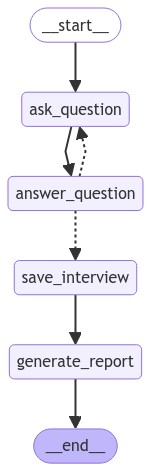

In [53]:
def save_interview(state: InterviewState):
    
    """ Save interviews """

    # Get messages
    messages = state["messages"]
    
    # Convert interview to a string
    interview = get_buffer_string(messages)
    
    # Save to interviews key
    return {"interviews": [interview]}

def route_messages(state: InterviewState, 
                   name: str = "expert"):

    """ Route between question and save interview (finish) """
    
    # Get messages
    messages = state["messages"]

    # Check the number of expert answers 
    num_responses = len(
        [m for m in messages if isinstance(m, AIMessage) and m.name == name]
    )

    # End if expert has answered more than the max turns
    if num_responses >= max_num_turns:
        return "save_interview"

    # This router is perform after each question - answer pair 
    # Get the last question asked to check if it signals the end of discussion
    last_question = messages[-2]
    
    if "Thank you so much for your help!" in last_question.content:
        return "save_interview"
    return "ask_question"

# Add nodes and edges 
interview_builder = StateGraph(InterviewState)
interview_builder.add_node("ask_question", generate_question)
interview_builder.add_node("answer_question", generate_answer)
interview_builder.add_node("save_interview", save_interview)
interview_builder.add_node("generate_report", generate_report) 

# Flow
interview_builder.add_edge(START, "ask_question")
interview_builder.add_edge("ask_question", "answer_question")
interview_builder.add_conditional_edges("answer_question", route_messages,["ask_question","save_interview"])
interview_builder.add_edge("save_interview", "generate_report")
interview_builder.add_edge("generate_report", END)

sub_graph = interview_builder.compile()
display(Image(sub_graph.get_graph(xray=1).draw_mermaid_png()))

Here is the full graph.

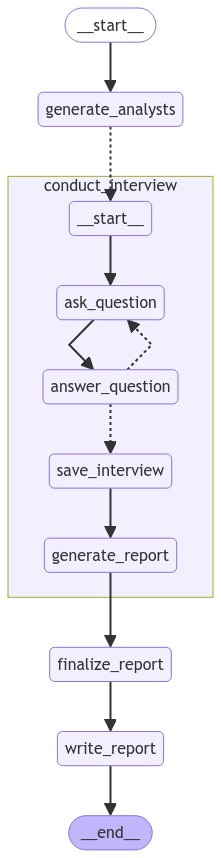

In [59]:
import time
import requests
from langgraph.constants import Send
from langgraph.checkpoint.sqlite import SqliteSaver

def initiate_all_interviews(state: ResearchGraphState):
    """ This is the "map" step where we run each interview sub-graph using Send API """    

    topic = state["topic"]
    return [Send("conduct_interview", {"analyst": analyst,
                                       "messages": [HumanMessage(
                                           content=f"So you said you were writing an article on {topic}?"
                                       )
                                                   ]}) for analyst in state["analysts"]]
    
def finalize_report(state: ResearchGraphState):
    """ The is the "reduce" step where we gather all the sections, and combine them """
    
     # Full set of interviews
    sections = state["reports"]

    # Combine them
    formatted_str_sections = "\n\n".join([f"{section}" for i, section in enumerate(sections, start=1)])

    # Write the intro
    final_report_gen_prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                
                """You are an expert analyst, writer, and editor. You will be given a full report.
    
                Write a crisp and compelling introduction for the report.

                Include no pre-amble for the introduction.
    
                Use markdown formatting. Use # header for the start along with a title for the full report.""",
            
            ),
            ("human", """Here are the interviews conducted with experts on this topic:
                            <sections>
                            {sections}
                            </sections>"""),
        ]
    )

    # Generate intro
    final_report_gen_chain = final_report_gen_prompt | report_writer_llm | StrOutputParser()
    report_intro = final_report_gen_chain.invoke({"sections": formatted_str_sections})

    # Save full / final report
    return {"final_report": report_intro + "\n\n" + formatted_str_sections}

def write_report(state: ResearchGraphState):
    """ Write the report to external service (Slack) """
    
    # Write to slack
    slack_fmt_promopt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                
                """Your goal is to first analyze a short report, which is in markdown.

                Then, re-format it in Slack blocks so that it can be written to the Slack API.
            
                Be sure to include divider blocks between each section of the report.""",
            
            ),
            ("human", """Here is the report to re-format: {report}"""),
        ]
    )

    # Full set of interview reports
    sections = state["reports"]

    # Write each section of the report indvidually 
    for section_to_write in sections:
    
        # Format the markdown as Slack blocks
        slack_fmt = slack_fmt_promopt | llm.with_structured_output(SlackBlock)
        slack_fmt_report = slack_fmt.invoke({"report": section_to_write})
        list_of_blocks = [block.dict() for block in slack_fmt_report.blocks]

        # Add a header
        true = True
        list_of_blocks.insert(0, {
            "type": "header",
            "text": {
                "type": "plain_text",
                "text": ":robot_face: Lance Bot has been busy ...",
                "emoji": true
            }
        })

        # Write to your Slack Channel via webhook
        headers = {
            'Content-Type': 'application/json',
        }
        data = {
            "blocks": list_of_blocks,
        }
        response = requests.post(slack_bot_url, headers=headers, json=data)

# Build the full graph
builder = StateGraph(ResearchGraphState, input=ResearchGraphStateInput)
builder.add_node("generate_analysts", generate_analysts)
builder.add_node("conduct_interview", interview_builder.compile())
builder.add_node("finalize_report", finalize_report)
builder.add_node("write_report", write_report)

builder.add_edge(START, "generate_analysts")
builder.add_conditional_edges("generate_analysts", initiate_all_interviews, ["conduct_interview"])
builder.add_edge("conduct_interview", "finalize_report")
builder.add_edge("finalize_report", "write_report")
builder.add_edge("write_report", END)

# Set memory
memory = SqliteSaver.from_conn_string(save_db_path)

# Compile
graph = builder.compile(checkpointer=memory, interrupt_before=["generate_analysts","write_report"],)
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [ ]:
# Thread used for memory
thread = {"configurable": {"thread_id": "2"}}

# Initial state
initial_state = {"topic": topic, 
                 "max_analysts": 5}

# Run the graph until the first interruption at the analyst generation step
for event in graph.stream(initial_state, thread, stream_mode="values"):
    print(event)

# Specify any analysts that you want to ensure we include
user_preference_analyst = input("Do you have any specific analyst personas that you want to include?")

# Update the state to include our feedback
updated_state = {"analyst_feedback": user_preference_analyst}
graph.update_state(thread, updated_state)

# Continue the graph execution
for event in graph.stream(None, thread, stream_mode="values"):
    print(event)

# Runs until we hit the final write report step
user_approval = input("Do you want to write the report to Slack? (yes/no): ")

if user_approval.lower() == "yes":
    # If approved, continue the graph execution to write to Slack
    for event in graph.stream(None, thread, stream_mode="values"):
        print(event)
else:
    print("Completed without writing to Slack")

View each section of the report - 

In [56]:
from IPython.display import Markdown
Markdown(graph.get_state(thread).values["reports"][0].replace("\n#", "\n##"))

Here is a short report based on the interview:

### Enhancing AI Performance Through Advanced Data Filtering: Insights from Meta's Llama 3.1

#### Problem

Large language models (LLMs) like Meta's Llama 3.1 require vast amounts of high-quality training data to perform well. However, web-scraped data often contains noise, irrelevant content, and formatting that can negatively impact model performance. Previous approaches to data cleaning were often insufficient, leaving in problematic elements like markdown syntax or failing to remove enough low-quality content.

#### Solution

Meta developed a sophisticated multi-step process to dramatically improve the quality of training data for Llama 3.1:

1. A custom HTML parser precisely extracts main content while removing boilerplate.

2. All markdown markers are stripped out, as they were found to harm model performance. This counterintuitive finding highlights the importance of plain text for training.

3. Aggressive de-duplication occurs at the URL, document, and line levels to eliminate redundant content.

4. Heuristic filtering removes low-quality text using techniques like duplicated n-gram coverage ratio and token distribution analysis.

5. Model-based quality filtering employs efficient DistilRoberta classifiers to score document quality.

This meticulous approach led to significant improvements in Llama 3.1's capabilities, particularly for tasks like long-form text summarization. In one case study, summaries became more consistent, accurate, and free of noise after filtering. The model demonstrated enhanced comprehension of complex information, achieving higher ROUGE scores and human evaluation ratings.

Implementing these techniques required overcoming challenges like balancing precision and recall in parsing, preserving context when removing markdown, and efficiently processing multilingual data. Through iterative refinement and sophisticated algorithms, Meta successfully enhanced data quality, ultimately boosting Llama 3.1's performance across various tasks.

View the full, final report - 

In [162]:
from IPython.display import Markdown
Markdown(graph.get_state(thread).values["final_report"].replace("\n#", "\n##"))

See the overall trace, for 5 analysts:

* `77 sec`
* `$1.52` 
* `300k tokens`

https://smith.langchain.com/public/c2edc705-a6cc-43dc-aed9-4b8ef9cf48e1/r